In [26]:
from data import get_data_and_loss_fn
import torch 
from torch import nn
from seed import set_seed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import AdaLoraConfig, AdaLoraModel
from training import train_model
from evaluation import evaluate_model
from visualizations import plot_confusion_matrix
from predict import get_prediction

In [18]:
filenames = ['tripadvisor_hotel_reviews.csv']
X_col = "Review"
y_col = "Rating"
model_name_bert = "bert-large-uncased"
model_name_roberta = "roberta-large"
test_size = 0.2
classification = True
seed = 42
batch_size = 64
max_len = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5
n_epochs = 20

In [7]:
train_loader_bert, test_loader_bert, loss_fn_bert = get_data_and_loss_fn(filenames=filenames,
                                                          X_column_name=X_col,
                                                          y_column_name=y_col,
                                                          tokenizer_name=model_name_bert,
                                                          classification=classification,
                                                          test_size=test_size,
                                                          random_state=seed,
                                                          batch_size=batch_size,
                                                          max_length=max_len,
                                                          device=device)

train_loader_roberta, test_loader_roberta, loss_fn_roberta = get_data_and_loss_fn(filenames=filenames,
                                                          X_column_name=X_col,
                                                          y_column_name=y_col,
                                                          tokenizer_name=model_name_roberta,
                                                          classification=classification,
                                                          test_size=test_size,
                                                          random_state=seed,
                                                          batch_size=batch_size,
                                                          max_length=max_len,
                                                          device=device)

In [ ]:
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name_bert, num_labels=num_classes).to(device)
model_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=num_classes).to(device)

In [9]:
config = AdaLoraConfig(
    peft_type="ADALORA",
    task_type="SEQ_CLS",
    init_r = 12,
    lora_alpha = 32,
    target_modules = ["query", "value"],
    lora_dropout = 0.1,
    total_step =257
)

adaloramodel_bert = AdaLoraModel(model_bert, config, "default")
adaloramodel_roberta = AdaLoraModel(model_roberta, config, "default")

In [10]:
adaloramodel_bert.load_state_dict(torch.load("adalora_new_data.pth"))
adaloramodel_roberta.load_state_dict(torch.load("adalora_new_data_roberta.pth"))

<All keys matched successfully>

In [15]:
results_bert = evaluate_model(adaloramodel_bert, test_loader_bert, device, num_classes)
results_roberta = evaluate_model(adaloramodel_roberta, test_loader_roberta, device, num_classes)

# Bert-Base-Uncased

precision:0.590993
recall:0.620364
f1:0.603217
acc:0.638936


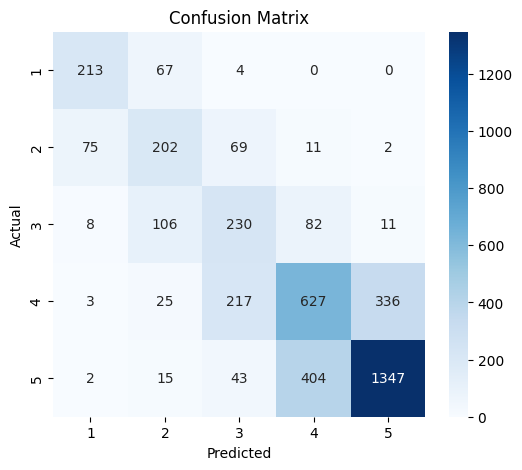

In [19]:
print(f"precision:{results_bert['precision']:2f}")
print(f"recall:{results_bert['recall']:2f}")
print(f"f1:{results_bert['f1']:2f}")
print(f"acc:{results_bert['acc']:2f}")
plot_confusion_matrix(results_bert['confusion_matrix'], class_names = [1, 2, 3, 4, 5])

# Roberta Large

precision:0.632947
recall:0.661382
f1:0.642456
acc:0.671139


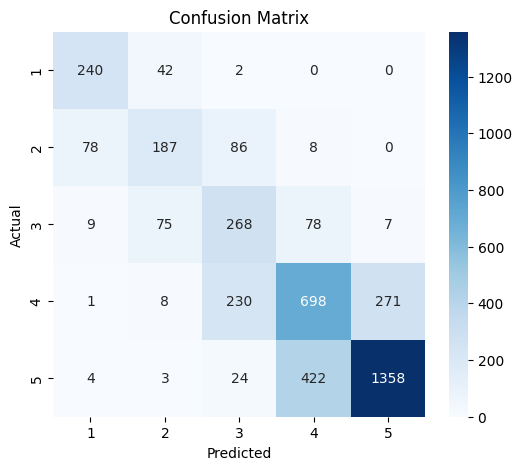

In [20]:
print(f"precision:{results_roberta['precision']:2f}")
print(f"recall:{results_roberta['recall']:2f}")
print(f"f1:{results_roberta['f1']:2f}")
print(f"acc:{results_roberta['acc']:2f}")
plot_confusion_matrix(results_roberta['confusion_matrix'], class_names = [1, 2, 3, 4, 5])

# Custom reviews test

In [27]:
reviews = [
    # Positive
    "The hotel exceeded my expectations! The staff were incredibly friendly, and the rooms were spotless and comfortable. I would definitely come back.",
    "Amazing location and fantastic service. Breakfast was delicious and the pool area was very relaxing. Highly recommend this place!",
    "Absolutely loved our stay. The hotel had a cozy atmosphere, and the staff made us feel very welcome. Everything was perfect.",

    # Neutral
    "The hotel was okay. The room was clean, but the service was just average. Nothing special, but nothing bad either.",
    "Decent stay, nothing extraordinary. The location was convenient, but the amenities could use some improvement.",
    "The hotel met my basic expectations. Room was adequate, but the overall experience was rather ordinary.",

    # Negative
    "Very disappointed with this hotel. The room was small and noisy, and the staff was unhelpful. I would not stay here again.",
    "The experience was terrible. Dirty rooms, slow service, and the food was disappointing. Definitely not worth the price.",
    "I regret choosing this hotel. Poor hygiene, uncomfortable beds, and rude staff made our stay very unpleasant."
]

tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name_roberta)

models = [(adaloramodel_bert, tokenizer_bert, "bert-large"), (adaloramodel_roberta, tokenizer_roberta, "roberta-large")]

In [28]:
for review in reviews:
    print(f"review: {review}")
    for model, tokenizer, name in models:
        print(f"{name}:")
        get_prediction(model, tokenizer, review, device)
    print("*"*100)

review: The hotel exceeded my expectations! The staff were incredibly friendly, and the rooms were spotless and comfortable. I would definitely come back.
bert-large:
5
roberta-large:
5
****************************************************************************************************
review: Amazing location and fantastic service. Breakfast was delicious and the pool area was very relaxing. Highly recommend this place!
bert-large:
5
roberta-large:
5
****************************************************************************************************
review: Absolutely loved our stay. The hotel had a cozy atmosphere, and the staff made us feel very welcome. Everything was perfect.
bert-large:
5
roberta-large:
5
****************************************************************************************************
review: The hotel was okay. The room was clean, but the service was just average. Nothing special, but nothing bad either.
bert-large:
3
roberta-large:
3
************************